#  Lecture 2: Discussion A

## Housekeeping
- Introduction: Christian
- Piazza Questions

## Discussion Goals
- Explore course content through code examples.
- Address themes of questions that are arising via Piazza.
- Teach how to approach the homework assignments.

## Discussion Format
- Two discussions per week
- Both discussions are pre-recorded and posted to Canvas
- A piazza forum will be created for each discussion and lecture.  Please direct all questions to the specific forum.
- Additional questions can be addressed at Office Hours.  We will have a regularly scheduled TA OH time slot, however it will be appointment only.

## Today's Plan
- Exploratory Data Analysis
- Linear Regression
- Batch Gradient Descent
- Demonstrate some common libraries (eg, Pandas, Sci-kit Learn, Numpy)

## Data Import

We will be using the iris dataset from UCI.  This is a very common dataset that is often used to demonstrate statistical or machine learning examples.

In [1]:
# setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata

In [2]:
# download the dataset and read into a DataFrame
CSV_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(CSV_URL, names=['sepal_length','sepal_width','petal_length','petal_width','class'])

In [3]:
# information on the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Exploratory Data Analysis

In [57]:
# show a few rows
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# summary statistics of numerical features
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


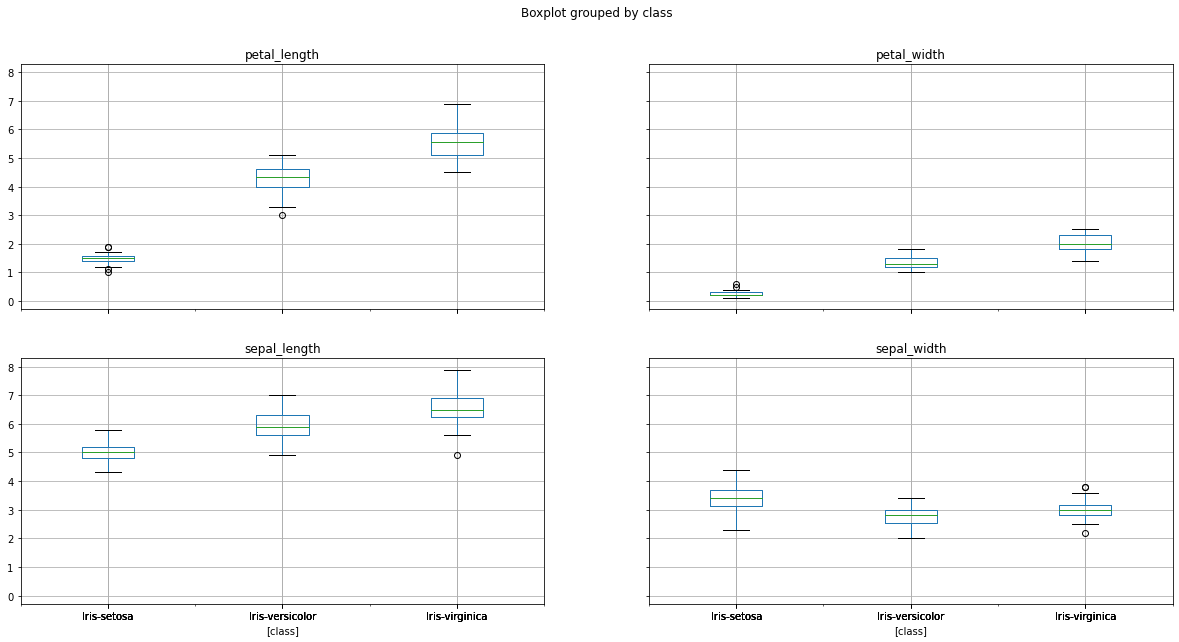

In [40]:
# another option for exploration
(ax1, ax2), (ax3,ax4) = df.boxplot(by='class', figsize=(20,10))

Observations:
- 3 classes
- Petal Length is probably a very good discriminator between the classes.
- Generally, very tight distributions.
- Versicolor and Virginica would be the hardest to discriminate between.

Let's take a closer look at petal_length:

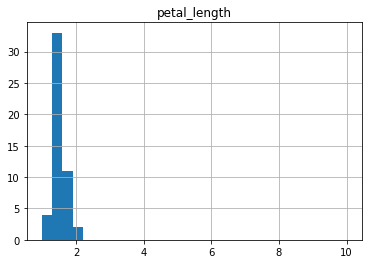

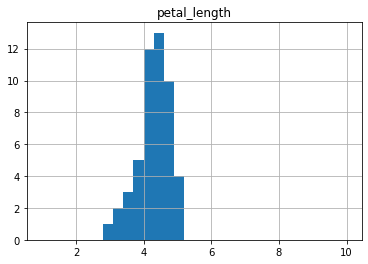

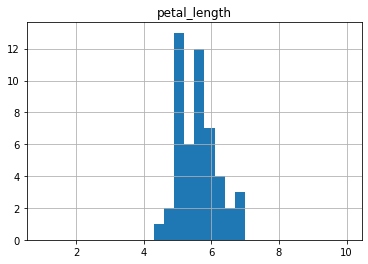

In [62]:
df.groupby("class").hist(['petal_length'], range=(1, 10), bins=30);

In [8]:
# correlation between features
df.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


If we were to use these features to predict the class of iris, then we would want to be careful about including any pairs that have high correlation to each other.  For example, if we wanted to use Logistic Regression to classify iris types, then we could have problems if we included both petal_length and petal_width.  When there are two perfectly correlated variables in a regression, it is called multicollinearity.  Both of the variables describe the same variance in the regression.

Petal Length and Petal Width and very strongly correlated.  Let's see if we can build a linear regression model to predict width from length.

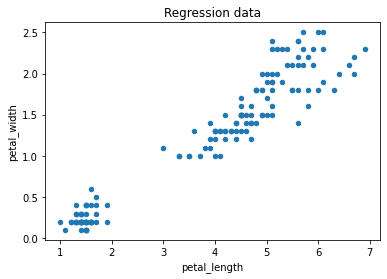

In [9]:
df.plot(kind="scatter", x="petal_length", y="petal_width", title='Regression data');

### Other ideas for exploratory data analysis
- Null values and patterns of nulls
- Working with categorical or string data

## Regression

Our goal is to calculate the line with equation

$y = mx + b$

that minimizes the error.


We will use Mean Square Error as our loss function:

$MSE = \frac{1}{N} \sum_{i=1}^N (y_i - \hat y_i)^2$


In this case $\hat y_i$ is the value that our linear regression predicts.  We can replace $\hat y_i$:

$MSE = \frac{1}{N} \sum_{i=1}^N (y_i - (mx_i + b))^2$


Taking the gradient of the loss function:

$\frac{df}{dm} = \frac{1}{N} \sum_{i=1}^N 2x_i*(y_i - (m x_i + b))$

$\frac{df}{db} = \frac{1}{N} \sum_{i=1}^N 2*(y_i - (m x_i + b))$

Let's visualize what our algorithm is doing.

On the right is a plot of our optimization over the problem domain space (ie. fitting y=mx+b).  On the left is a plot of error surface calculated from the MSE.  We are trying to minimize the error, so we take steps towards the local minimum as indicated by the progressive red dots.

In [10]:
from IPython.display import Image
Image(url='https://alykhantejani.github.io/images/gradient_descent_line_graph.gif')

### Approach

- Prepare the data
- Split the data into training and test sets at random
- Fit the model to the data using batch gradient descent
- Compare hyperparameters

In [11]:
def train_test_split(df_input, train_fraction, random_state=12):
    # or use: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    df_shuffled = df_input.sample(frac=1, random_state=random_state)
    train_size = round(train_fraction*len(df_shuffled))
    test_size = len(df_shuffled) - train_size
    train = df_shuffled.loc[np.random.choice(df_shuffled.index.values, train_size,replace=False)]
    test = df_shuffled.loc[np.setdiff1d(df_shuffled.index.values, train.index.values)]
    return train, test

In [12]:
# split the data

train, test = train_test_split(df, 0.8)
X_train = train["petal_length"]
y_train = train["petal_width"]
X_test = test["petal_length"]
y_test = test["petal_width"]

In [13]:
class SimpleLinearRegression:
    def __init__(self):
        # log to keep track of training
        self.log = []
        
    def fit(self, X, y, lr, number_epochs, m_initial=0, b_initial=0):
        # features (petal length)
        self.X = X
        
        # outcome (petal width)
        self.y = y
        
        # slope
        self.m = m_initial
        
        # intercept
        self.b = b_initial
        
        # initialize the log
        self.log.append({"epoch": 0, "MSE": self.score(self.predict(self.X), self.y), "m": self.m, "b": self.b})
        
        # batch gradient descent
        for i in range(number_epochs):
            grad_m, grad_b = self.compute_gradient()
            self.update_weights(lr, grad_m, grad_b)
            self.log.append({"epoch": i+1, "MSE": self.score(self.predict(self.X), self.y),  "m": self.m, "b": self.b})
            # if loss of this run - loss of prior run < 0.00001 then exit

    def compute_gradient(self):
        predicted = self.predict(self.X)
        grad_m = -2*np.mean(self.X*(self.y-predicted))
        grad_b = -2*np.mean((self.y-predicted))
        return grad_m, grad_b

    def update_weights(self,lr,grad_m, grad_b):
        self.m -= lr * grad_m
        self.b -= lr* grad_b

    def score(self, predicted, actual):
        # compute the MSE
        return np.mean((actual-predicted)**2)
    
    def predict(self,X):
        # use the trained m and b to predict a value of y
        return self.m*X + self.b
        

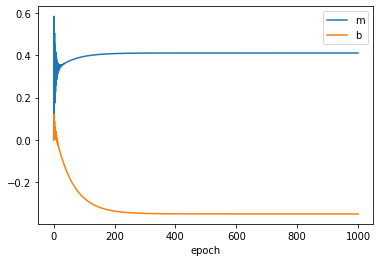

In [70]:
reg = SimpleLinearRegression()
reg.fit(X_train, y_train, .05,1000,0,0 )
df_lr = pd.DataFrame(reg.log)
df_lr.plot(kind="line", x="epoch", y=['m','b']);

In [69]:
df_lr.tail()

,epoch,MSE,m,b
996,996,0.044824,0.408624,-0.337949
997,997,0.044823,0.408635,-0.337997
998,998,0.044823,0.408645,-0.338044
999,999,0.044823,0.408655,-0.338091
1000,1000,0.044823,0.408666,-0.338138


In [16]:
reg2 = SimpleLinearRegression()
reg2.fit(X_train, y_train, .01,300,-5,-5 )

In [17]:
reg3 = SimpleLinearRegression()
reg3.fit(X_train, y_train, .001,300,0,0 )

In [18]:
reg4 = SimpleLinearRegression()
reg4.fit(X_train, y_train, .1,200,0,0 )

In [66]:
def log2surface(regressionModel, ax, title):
    df = pd.DataFrame(regressionModel.log)
    x1 = np.linspace(df['m'].min(), df['m'].max(), len(df['m'].unique()))
    y1 = np.linspace(df['b'].min(), df['b'].max(), len(df['b'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['m'], df['b']), df['MSE'], (x2, y2), method='nearest')

    # Plot the surface.
    surf = ax.plot_surface(x2, y2, z2,
                           linewidth=0, antialiased=False)
    ax.set_xlabel('m')
    ax.set_ylabel('b')
    ax.set_zlabel('MSE')
    
    score = regressionModel.score(regressionModel.predict(X_test), y_test)
    ax.set_title(f'{title}\nm={round(df["m"].iloc[-1],2)}, b={round(df["b"].iloc[-1],2)}\nTrain MSE_n-1= {round(df["MSE"].iloc[-2],4)}\nTrain MSE_n={round(df["MSE"].iloc[-1],4)}\nTest MSE={round(score,4)}')

c:\users\cmillsop\source\data\lib\site-packages\numpy\linalg\linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


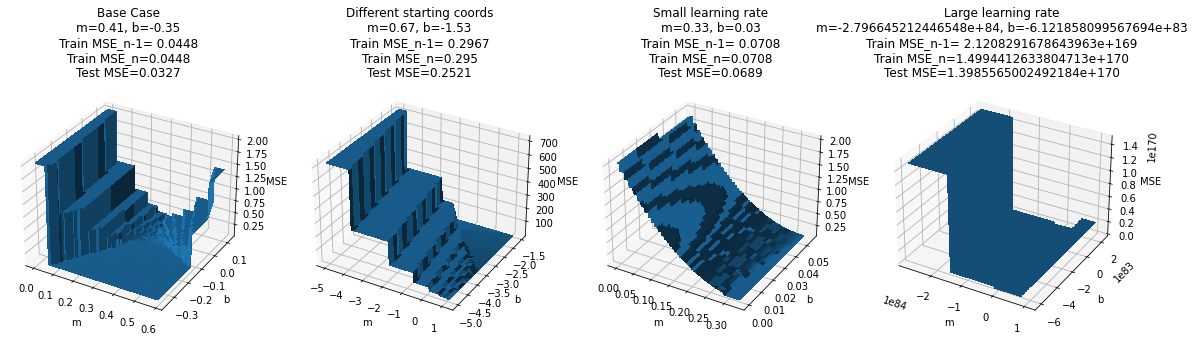

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,10),subplot_kw=dict(projection='3d'))
log2surface(reg, ax1, 'Base Case')
log2surface(reg2, ax2, 'Different starting coords')
log2surface(reg3, ax3, 'Small learning rate')
log2surface(reg4, ax4, 'Large learning rate')

Another way to address the hyperparameter puzzle is by performing a grid search.  A popular implementation is packaged in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Gradient Descent Notes:
- Learning Rate is how fast we descend a surface.  If it's too big than we may overshoot and never converge.  If it's too small we may never converge in a reasonable number of epochs.
- Starting Point is what we initialize the parameters to before we start optimizing.  Depending upon the shape of the error surface, we may affect how long it takes to converge or we may reach a different local minimum.
- In multi-parameter models it is very important to normalize the ranges of the features prior to performing gradient descent.  If the features are not all on the same scale, then the error surface may be shaped like an oval instead of a circle, which may impact optimization performance.  The learning rate is constant for all parameters.  So it may be too large in one direction and too small in another direction.
- A convex surface is important for gradient descent.  We want to find the _global_ minimum rather than the _local_ minimum if possible.

### Sanity Check

Were our results reasonable?  Let's compare to sklearn's LinearRegression

In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression
lr = LinearRegression()
lr.fit(X_train.to_numpy().reshape(-1,1), y_train.to_numpy().reshape(-1,1))
predicted = lr.predict(X_test.to_numpy().reshape(-1,1))

print(f'Test MSE: {round(mean_squared_error(predicted, y_test),4)}')

Test MSE: 0.0327


In [32]:
print(f'y = {round(lr.coef_[0][0],2)} x {round(lr.intercept_[0],2)}')

y = 0.41 x -0.35


Our model performs almost as well as the sklearn model, especially at high epoch number (1000) or slightly larger learning rate.